In [27]:
import spotipy
from openpyxl import Workbook
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import numpy as np
from pprint import pprint

In [2]:
cid = '---'
secret = '---'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [3]:
creator = "spotify"
playlist_id = "4yORtoAH6JYDkp0ZnXo969"



# Step 1
playlist_features_list = ["artist", "album", "track_name", "track_id", "artist_id", "genre", "danceability",
                         "energy", "key", "loudness", "mode", "speechiness", "instrumentalness", "liveness",
                         "valence", "tempo", "duration_ms", "time_signature"]
playlist_df = pd.DataFrame(columns=playlist_features_list)

# Step 2
playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
for track in playlist:
    # Create empty dict
    playlist_features = {}

    # Get metadata
    playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
    playlist_features["album"] = track["track"]["album"]["name"]
    playlist_features["track_name"] = track["track"]["name"]
    playlist_features["track_id"] = track["track"]["id"]
    playlist_features["explicit"] = track["track"]["explicit"]
    playlist_features["popularity"] = track["track"]["popularity"]
    playlist_features["artist_id"] = track["track"]["album"]["artists"][0]["id"]

    # Get audio features
    audio_features = sp.audio_features(playlist_features["track_id"])[0]
    for feature in playlist_features_list[6:]:
        playlist_features[feature] = audio_features[feature]

    # Get genre
    genres = sp.artist(playlist_features['artist_id'])['genres']
    if genres:
        genre_str = ', '.join(genres)
        first_genre = genre_str.split(",")[0]
        playlist_features['genre'] = first_genre

    # Concat the dfs
    track_df = pd.DataFrame(playlist_features, index=[0])
    playlist_df = pd.concat([playlist_df, track_df], ignore_index=True)


In [4]:
#Analyze DataFrame
playlist_df.head(2)

,artist,album,track_name,track_id,artist_id,genre,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,popularity
0,Mark Ronson,Uptown Funk (Remixes) (feat. Bruno Mars),Uptown Funk (feat. Bruno Mars),57n3qOwXcoRMyGFjeqC1Rh,3hv9jJF3adDNsBSIQDqcjp,dance pop,0.856,0.609,0,-7.223,1,0.0824,0.000082,0.0344,0.928,114.988,269667,4,True,41.0
1,LMFAO,Sorry For Party Rocking (Deluxe Version),Party Rock Anthem,7FwaX3u4lo5wqF2mdHQlsC,3sgFRtyBnxXD5ESfmbK4dl,dance pop,0.751,0.736,5,-4.168,0,0.1560,0.000000,0.2650,0.352,130.014,262147,4,False,33.0


In [5]:
playlist_df.dtypes

artist               object
album                object
track_name           object
track_id             object
artist_id            object
genre                object
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms          object
time_signature       object
explicit             object
popularity          float64
dtype: object

In [6]:
playlist_df['duration_ms'] = playlist_df['duration_ms'].astype(int)

In [7]:
#Drop the columns we will not need for the regression
playlist_df =  playlist_df.drop(['track_name', 'album', 'artist', 'track_id', 'artist_id', 'time_signature', 'explicit', 'key', 'mode'], axis = 1).copy()

In [8]:
playlist_df.head(50)

,genre,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,popularity
0,dance pop,0.856,0.609,-7.223,0.0824,0.000082,0.0344,0.928,114.988,269667,41.0
1,dance pop,0.751,0.736,-4.168,0.1560,0.000000,0.2650,0.352,130.014,262147,33.0
2,pop,0.825,0.652,-3.183,0.0802,0.000000,0.0931,0.931,95.977,233713,64.0
3,dance pop,0.748,0.524,-5.599,0.0338,0.000000,0.1110,0.661,95.010,244960,81.0
4,pop,0.851,0.541,-6.825,0.0505,0.000000,0.1300,0.448,124.959,235545,62.0
5,barbadian pop,0.734,0.766,-4.485,0.0383,0.001380,0.1080,0.600,127.986,215227,58.0
6,lgbtq+ hip hop,0.878,0.619,-5.560,0.1020,0.000000,0.1130,0.639,136.041,157067,1.0
7,australian pop,0.864,0.495,-7.036,0.0370,0.000133,0.0992,0.720,129.062,244973,72.0
8,latin pop,0.653,0.816,-4.353,0.1670,0.000000,0.0967,0.816,178.085,228827,68.0
9,british soul,0.730,0.770,-5.114,0.0298,0.000000,0.0473,0.507,104.948,228093,0.0


In [9]:
categorical = ['genre']
numerical= ['tempo', 'energy', 'danceability', 'loudness', 'liveness', 'valence', 'duration_ms', 'instrumentalness', 
            'speechiness']
target = 'popularity'

In [10]:
for i in playlist_df.columns:
    print(playlist_df[i].value_counts())

dance pop                    36
pop                          12
canadian hip hop              5
dfw rap                       4
canadian pop                  4
art pop                       3
atl hip hop                   3
british soul                  3
modern rock                   2
baroque pop                   2
canadian contemporary r&b     2
barbadian pop                 2
contemporary country          1
reggae fusion                 1
australian pop                1
boy band                      1
chicago bop                   1
irish singer-songwriter       1
chicago rap                   1
lgbtq+ hip hop                1
folk-pop                      1
rap                           1
contemporary r&b              1
detroit hip hop               1
brostep                       1
pop rap                       1
latin pop                     1
deep classic garage rock      1
piano rock                    1
hip hop                       1
australian hip hop            1
neo soul

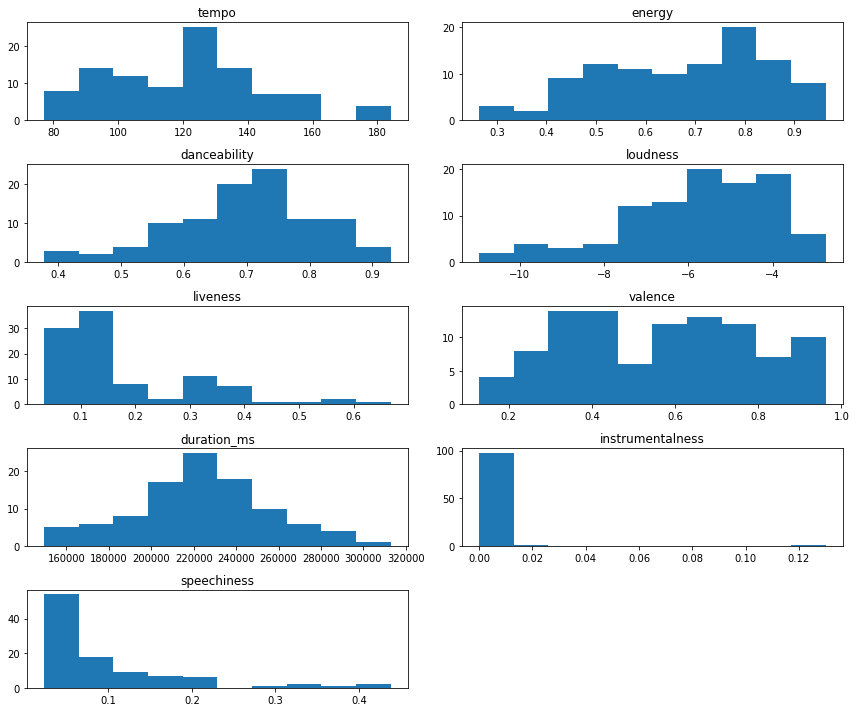

In [11]:
fig = plt.figure(figsize = (12, 10))
count = 1 
for i in numerical:
    ax = fig.add_subplot(5, 2, count)
    ax.hist(playlist_df[i])
    ax.set_title(i)
    count += 1

fig.tight_layout()
plt.show()

In [12]:
playlist_correlation = playlist_df.corr()
playlist_correlation

,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,popularity
danceability,1.000000,0.002701,-0.003454,0.033317,0.000338,-0.043961,0.326480,-0.119377,-0.130612,-0.122465
energy,0.002701,1.000000,0.710385,-0.019358,-0.159061,0.176915,0.465567,0.202547,0.002557,-0.101200
loudness,-0.003454,0.710385,1.000000,-0.242324,-0.319161,0.105794,0.321804,0.117856,0.123603,-0.076282
speechiness,0.033317,-0.019358,-0.242324,1.000000,0.333678,0.241624,0.012845,0.129499,-0.058538,0.074717
instrumentalness,0.000338,-0.159061,-0.319161,0.333678,1.000000,-0.032789,-0.015991,0.088922,-0.095911,0.049017
liveness,-0.043961,0.176915,0.105794,0.241624,-0.032789,1.000000,-0.111067,0.148201,-0.014955,-0.060839
valence,0.326480,0.465567,0.321804,0.012845,-0.015991,-0.111067,1.000000,0.175066,-0.095362,-0.095408
tempo,-0.119377,0.202547,0.117856,0.129499,0.088922,0.148201,0.175066,1.000000,0.130294,-0.112787
duration_ms,-0.130612,0.002557,0.123603,-0.058538,-0.095911,-0.014955,-0.095362,0.130294,1.000000,-0.050479
popularity,-0.122465,-0.101200,-0.076282,0.074717,0.049017,-0.060839,-0.095408,-0.112787,-0.050479,1.000000


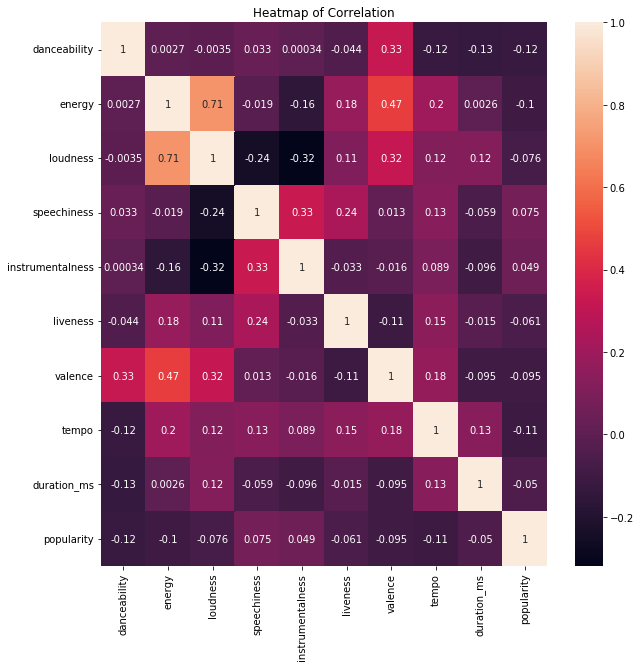

In [13]:
plt.figure(figsize=(10,10))
plt.title("Heatmap of Correlation")
sns.heatmap(playlist_correlation, annot=True)

In [14]:
#Drop loudness as it has high multicollinearity with energy
playlist_final = playlist_df.drop("loudness", axis=1).copy()
playlist_final

,genre,danceability,energy,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,popularity
0,dance pop,0.856,0.609,0.0824,0.000082,0.0344,0.928,114.988,269667,41.0
1,dance pop,0.751,0.736,0.1560,0.000000,0.2650,0.352,130.014,262147,33.0
2,pop,0.825,0.652,0.0802,0.000000,0.0931,0.931,95.977,233713,64.0
3,dance pop,0.748,0.524,0.0338,0.000000,0.1110,0.661,95.010,244960,81.0
4,pop,0.851,0.541,0.0505,0.000000,0.1300,0.448,124.959,235545,62.0
...,...,...,...,...,...,...,...,...,...,...
95,pop rap,0.685,0.731,0.4140,0.000000,0.3690,0.266,145.245,247867,63.0
96,dance pop,0.666,0.899,0.0280,0.000000,0.0677,0.629,122.050,186267,57.0
97,canadian hip hop,0.735,0.482,0.1390,0.014400,0.4480,0.315,181.995,217933,0.0
98,pop,0.530,0.422,0.0342,0.000000,0.1070,0.349,119.964,221360,80.0


In [16]:
#create dummy variabels and drop the variable with most instances
dummies_dropped = pd.get_dummies(playlist_final['genre'])
dummies_dropped = dummies_dropped.drop(columns = ['dance pop', 'pop rap', 'reggae fusion'])


In [17]:
# drop genre column and merge with dummies 
playlist_final = playlist_final.drop('genre', axis = 1).copy()
playlist_final = pd.concat([playlist_final, dummies_dropped], axis = 1)
playlist_final.head(2)

,danceability,energy,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,art pop,...,folk-pop,hip hop,irish singer-songwriter,latin pop,lgbtq+ hip hop,modern rock,neo soul,piano rock,pop,rap
0,0.856,0.609,0.0824,0.000082,0.0344,0.928,114.988,269667,41.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.751,0.736,0.1560,0.000000,0.2650,0.352,130.014,262147,33.0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X = playlist_final.loc[:, playlist_final.columns != 'popularity']
y = playlist_final['popularity']
X1 = sm.add_constant(X)

#split the data using SKlearn
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=0)

In [26]:
#print model 
method = sm.regression.linear_model.OLS(y_train.values.ravel(), X_train, has_constant = True)
result = method.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     2.269
Date:                Tue, 14 Feb 2023   Prob (F-statistic):            0.00848
Time:                        23:01:17   Log-Likelihood:                -296.06
No. Observations:                  70   AIC:                             656.1
Df Residuals:                      38   BIC:                             728.1
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['has_constant']
  warnings.warn(msg, ValueWarning)


In [21]:
cols = list(X.columns)
pmax = 1 #placeholder for new p-value max
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1,prepend = True, has_constant = 'add')
    model = sm.OLS(y,X_1, hasconst = True).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)    
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['energy', 'barbadian pop', 'boy band', 'british soul', 'canadian hip hop', 'hip hop', 'lgbtq+ hip hop']


In [22]:
X = playlist_final.loc[:, selected_features_BE]
y = playlist_final.loc[:,target]

#scaling our variables
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_1 = sm.add_constant(X, prepend = True, has_constant = 'add')

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3, random_state=0)

In [23]:
method = sm.regression.linear_model.OLS(y_train.values.ravel(), X_train, hasconst = True)
result = method.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     13.60
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           7.84e-10
Time:                        21:26:25   Log-Likelihood:                -303.64
No. Observations:                  70   AIC:                             621.3
Df Residuals:                      63   BIC:                             637.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.3268      2.323     25.536      0.0